In [18]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

# logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

# warnings.simplefilter("ignore")

In [19]:
# !kaggle datasets download -d shashwatwork/fruitnet-indian-fruits-dataset-with-quality

In [20]:
# !unzip -q fruitnet-indian-fruits-dataset-with-quality.zip -d data

In [21]:
import pathlib
sdir = r"data/Processed Images_Fruits"
bad_path = r"data/Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"data/Processed Images_Fruits/Good Quality_Fruits"
mixed_path = r"data/Processed Images_Fruits/Mixed Qualit_Fruits"

BATCH_SIZE = 64
IMG_SIZE = (224, 224)
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 


,filepaths,labels
0,data/Processed Images_Fruits/Bad Quality_Fruit...,Banana_Bad
1,data/Processed Images_Fruits/Bad Quality_Fruit...,Banana_Bad
2,data/Processed Images_Fruits/Bad Quality_Fruit...,Banana_Bad
3,data/Processed Images_Fruits/Bad Quality_Fruit...,Banana_Bad
4,data/Processed Images_Fruits/Bad Quality_Fruit...,Banana_Bad
...,...,...
19521,data/Processed Images_Fruits/Mixed Qualit_Frui...,Banana_mixed
19522,data/Processed Images_Fruits/Mixed Qualit_Frui...,Banana_mixed
19523,data/Processed Images_Fruits/Mixed Qualit_Frui...,Banana_mixed
19524,data/Processed Images_Fruits/Mixed Qualit_Frui...,Banana_mixed


In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sdir, 
    validation_split=0.2, 
    subset="training", 
    seed=123, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE)

Found 19526 files belonging to 3 classes.
Using 15621 files for training.


In [23]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sdir, 
    validation_split=0.2, 
    subset="validation", 
    seed=123, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE)

Found 19526 files belonging to 3 classes.
Using 3905 files for validation.


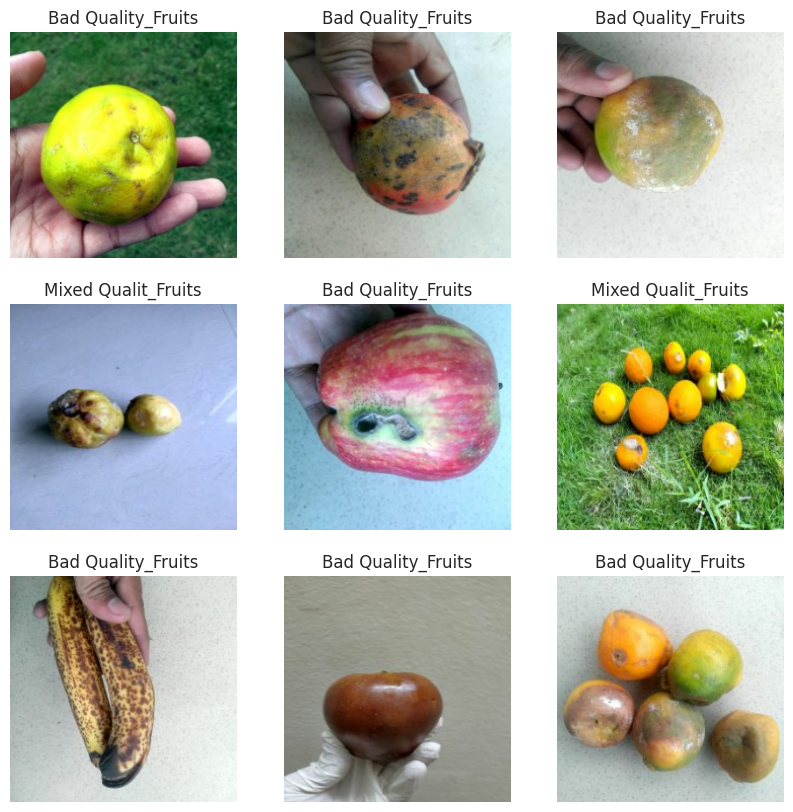

In [24]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [26]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of validation batches: 50
Number of test batches: 12


In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [28]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

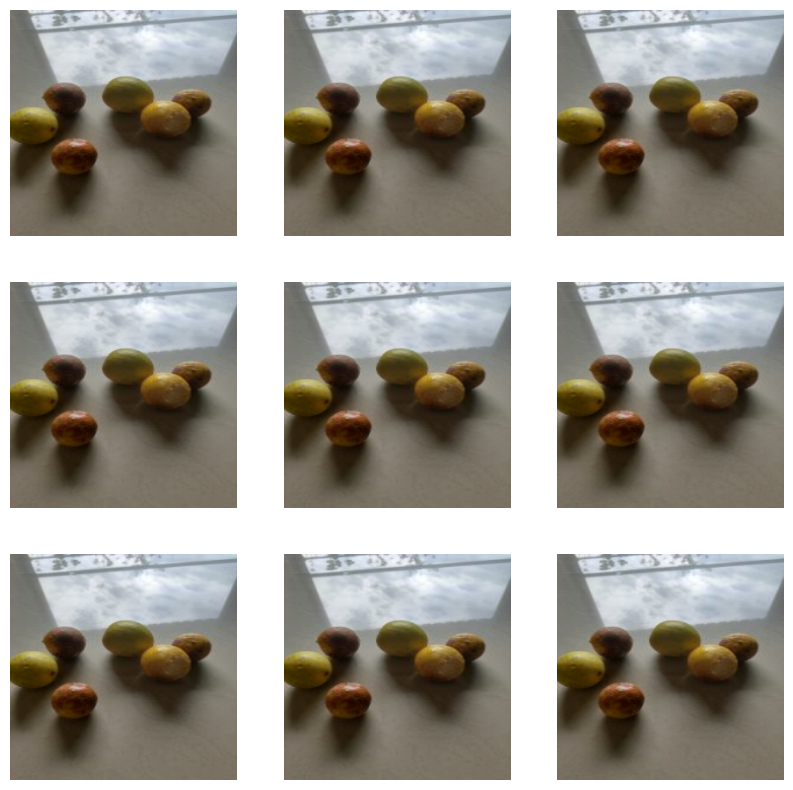

In [29]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [30]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [31]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [32]:
# IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3), 
                                                     include_top=False, 
                                                     weights="imagenet")

In [33]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1536)


In [34]:
base_model.trainable = False

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1536)


In [36]:
prediction_layer = tf.keras.layers.Dense(len(class_names) ,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3)


In [37]:
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [38]:
# from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
# from tensorflow.keras.models import Sequential

# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Flatten())
# model.add(Dense(1024, activation="relu"))
# model.add(Dense(512, activation="relu"))
# model.add(Dense(3, activation="softmax" , name="classification"))

In [39]:
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
# from keras.models import Sequential
# from keras import optimizers

# model_finetuned = Sequential()
# model_finetuned.add(base_model)
# model_finetuned.add(Dense(512, activation='relu', input_dim=IMG_SHAPE))
# model_finetuned.add(Dropout(0.3))
# model_finetuned.add(Dense(512, activation='relu'))
# model_finetuned.add(Dropout(0.3))
# model_finetuned.add(Dense(3, activation='sigmoid'))

In [40]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                             

In [42]:
len(model.trainable_variables)

2

In [43]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

 1/50 [..............................] - ETA: 8:43 - loss: 1.1506 - accuracy: 0.3750

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds, batch_size=64)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning**

Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Compile the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds, batch_size=64)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')